In [1]:
import torch
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_

from torchvision.transforms import (
    CenterCrop,
    Compose,
    InterpolationMode,
    RandomHorizontalFlip,
    Resize,
    ToTensor,
)

from datasets import load_dataset
from diffusers.optimization import get_scheduler
from tqdm.auto import tqdm
from torchinfo import summary

from scheduler import DDIMScheduler
from model import UNet
from utils import save_images, normalize_to_neg_one_to_one, plot_losses
from dataset import CustomDataset, make_dataset
import pandas as pd

[2023-06-30 02:27:34,764] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [3]:
dataset_name="cifar10"
resolution="32"
train_batch_size=4

data_path ={
    'mnist': '/root/data/MNIST',
    'cifar10': '/root/data/cifar10/cifar10/untracked',    
}[dataset_name]

_, dataset = make_dataset(dataset_name, data_path)

train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=train_batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# for step, batch in enumerate(train_dataloader):
#     print(batch)
#     break
len(batch)

2

In [ ]:
#### args


learning_rate
adam_beta1
adam_beta2
adam_weight_decay
adam_epsilon

num_epochs
gradient_accumulation_steps

device = "cuda:0"


In [ ]:
model = UNet(3,
                 image_size=resolution,
                 hidden_dims=[128, 256, 512, 1024],
                 use_linear_attn=False)
noise_scheduler = DDIMScheduler(num_train_timesteps=1000, beta_schedule="cosine")

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=learning_rate,
    betas=(adam_beta1, adam_beta2),
    weight_decay=adam_weight_decay,
    eps=adam_epsilon,
)

augmentations = Compose([
    Resize(resolution, interpolation=InterpolationMode.BILINEAR),
    CenterCrop(resolution),
    RandomHorizontalFlip(),
    ToTensor(),
])

lr_scheduler = get_scheduler(
    lr_scheduler,
    optimizer=optimizer,
    num_warmup_steps=lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * num_epochs) //
    gradient_accumulation_steps,
)

model = model.to(device)


check images

In [12]:
import os

path = "/root/diffusion/test_samples"
img = []
for i in os.listdir(path):
    for j in os.listdir(os.path.join(path, i)):
        if 'grid' in j:
            # print(os.path.join(path, i, j))
            img.append(str(os.path.join(path, i, j)))
img

['/root/diffusion/test_samples/20230630_024805_cifar10_0/0_grid.jpeg',
 '/root/diffusion/test_samples/20230630_030450_cifar10_20/20_grid.jpeg',
 '/root/diffusion/test_samples/20230630_032952_cifar10_50/50_grid.jpeg',
 '/root/diffusion/test_samples/20230630_035500_cifar10_80/80_grid.jpeg',
 '/root/diffusion/test_samples/20230630_031310_cifar10_30/30_grid.jpeg',
 '/root/diffusion/test_samples/20230630_025627_cifar10_10/10_grid.jpeg',
 '/root/diffusion/test_samples/20230630_024513_cifar10_0/0_grid.jpeg',
 '/root/diffusion/test_samples/20230630_032132_cifar10_40/40_grid.jpeg',
 '/root/diffusion/test_samples/20230630_024223_cifar10_0/0_grid.jpeg',
 '/root/diffusion/test_samples/20230630_033815_cifar10_60/60_grid.jpeg',
 '/root/diffusion/test_samples/20230630_040323_cifar10_90/90_grid.jpeg',
 '/root/diffusion/test_samples/20230630_034638_cifar10_70/70_grid.jpeg']

ValueError: x and y can be no greater than 2D, but have shapes (138,) and (138, 274, 3)

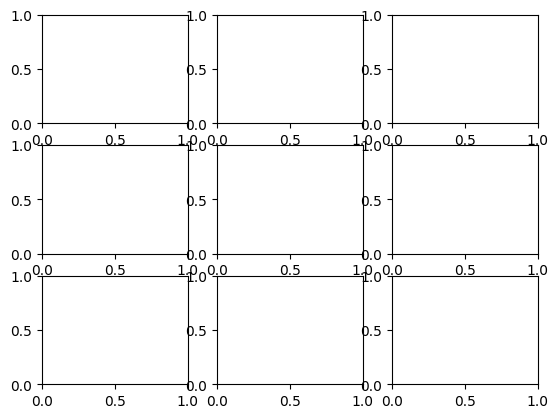

In [16]:
import PIL.Image as Image
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3)
axes = axes.flat

for i in img:
    ax = next(axes)
    ax.plot(Image.open(i).convert("RGB"))
